Loading CSVs...
Ask shape: (35220, 2), Bid shape: (35220, 2)
Merged data preview:


,MidPrice,Volume
Time (UTC),,
2023-01-02 23:00:00,24.0920,0.6990
2023-01-02 23:05:00,24.1165,3.0008
2023-01-02 23:10:00,24.0020,1.7850
2023-01-02 23:15:00,24.0040,1.7880
2023-01-02 23:20:00,24.0480,1.7924


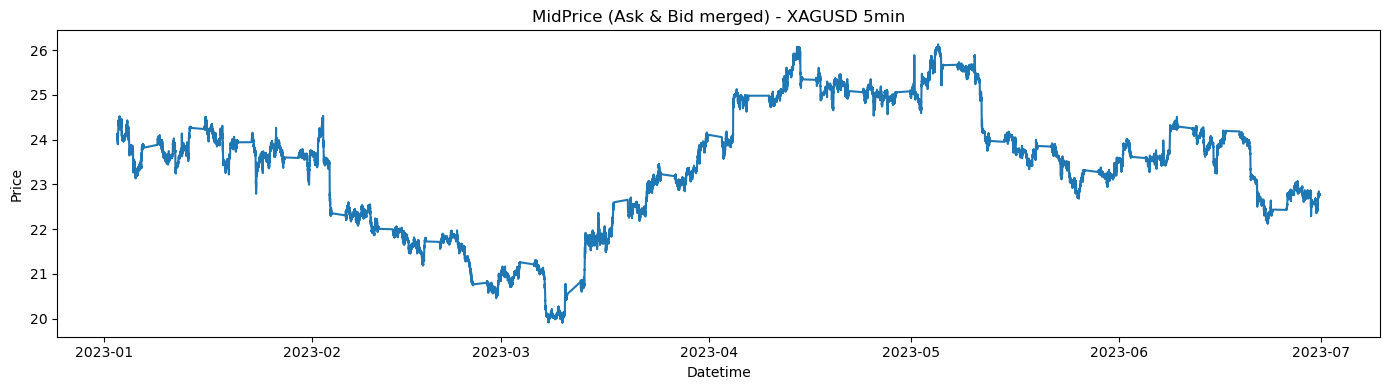

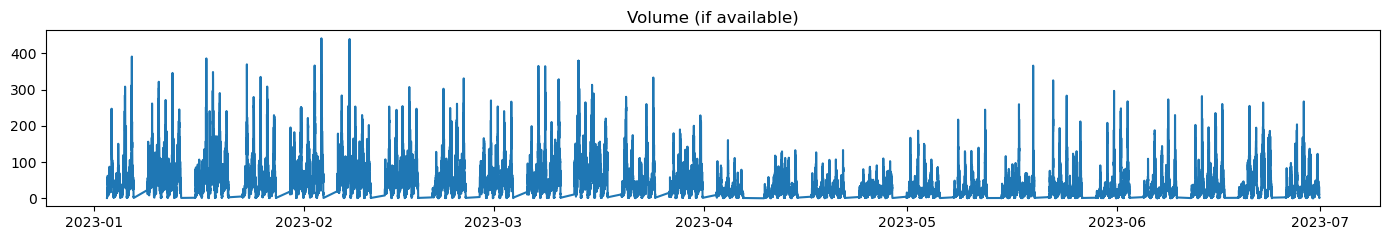

Created sequences: X shape (35203, 12, 1), y shape (35203,)
Train shape (28162, 12, 1), Test shape (7041, 12, 1)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
388/388 - 31s - 79ms/step - loss: 0.0113 - mae: 0.0678 - val_loss: 1.4460e-04 - val_mae: 0.0093
Epoch 2/80
388/388 - 11s - 29ms/step - loss: 0.0037 - mae: 0.0435 - val_loss: 1.4927e-04 - val_mae: 0.0088
Epoch 3/80
388/388 - 11s - 29ms/step - loss: 0.0028 - mae: 0.0385 - val_loss: 1.0653e-04 - val_mae: 0.0067
Epoch 4/80
388/388 - 25s - 64ms/step - loss: 0.0023 - mae: 0.0347 - val_loss: 1.2581e-04 - val_mae: 0.0083
Epoch 5/80
388/388 - 17s - 44ms/step - loss: 0.0019 - mae: 0.0317 - val_loss: 1.0790e-04 - val_mae: 0.0071
Epoch 6/80
388/388 - 11s - 28ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 2.2840e-04 - val_mae: 0.0122
Epoch 7/80
388/388 - 12s - 30ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 1.6887e-04 - val_mae: 0.0099
Epoch 8/80
388/388 - 20s - 52ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 1.7338e-04 - val_mae: 0.0101
Epoch 9/80
388/388 - 11s - 28ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 1.1112e-04 - val_mae: 0.0072
Epoch 10/80
388/388 - 11s - 29ms/step

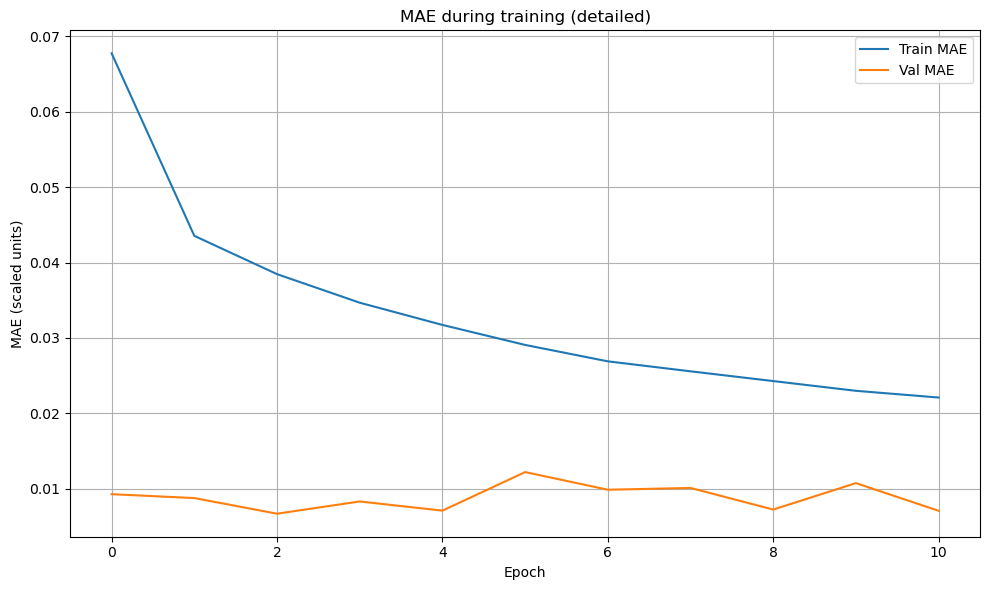

MAE training plot saved to: C:\Users\DELL\anaconda3\MAE_training_plot.png
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Test MSE (price units): 0.003423
Test MAE (price units): 0.038945


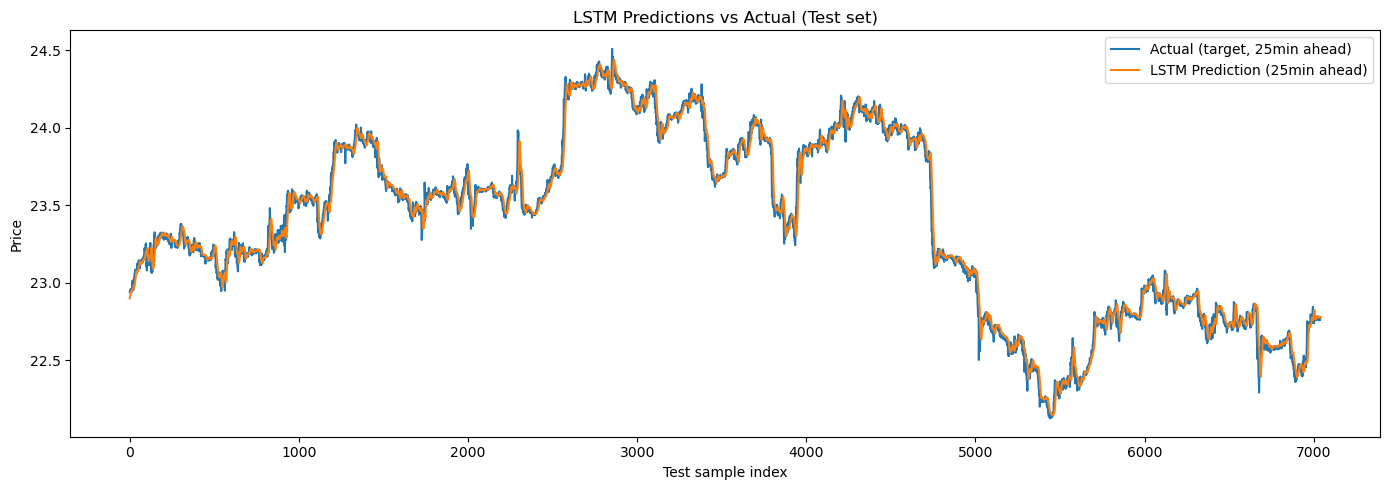

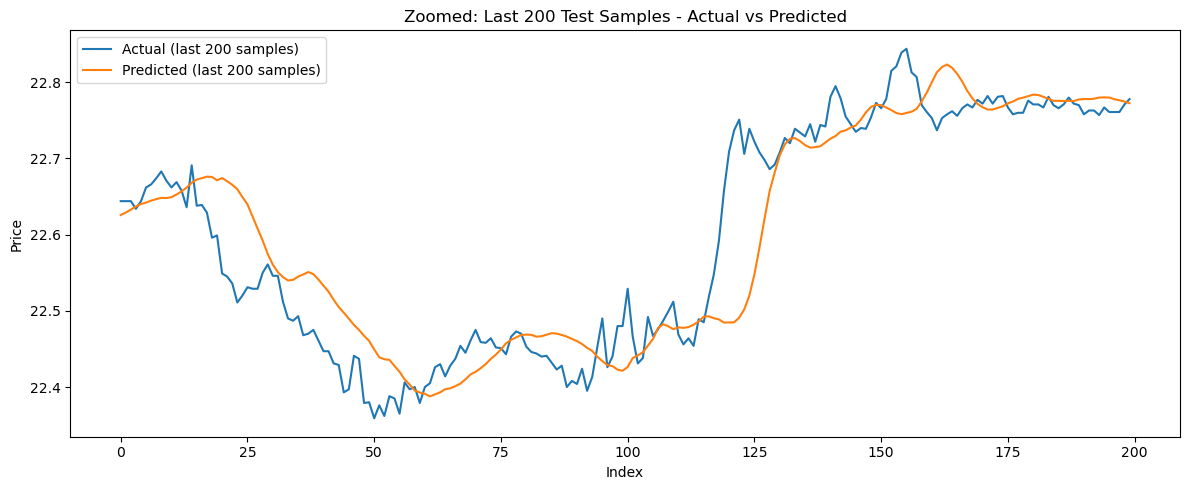

Model saved as 'xagusd_lstm_25min.h5' (optional)

Lab Logbook deliverable: include the 'MAE_training_plot.png' image (detailed MAE during training).


In [1]:
# LSTM pipeline for XAGUSD 5-min -> predict 25 minutes ahead (5 steps)
# Paste and run this cell in your notebook (expects the two CSV files in working dir)
# Filenames expected (edit if your files have different names):
ask_file = 'XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv'
bid_file = 'XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv'

# -------------- IMPORTS --------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# -------------- HELPER TO PARSE CSV (flexible) --------------
def load_price_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, low_memory=False)
    # try to locate datetime column
    dt_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
    if len(dt_candidates) == 0:
        # assume first column is datetime
        dt_col = df.columns[0]
    else:
        dt_col = dt_candidates[0]
    df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
    df = df.dropna(subset=[dt_col])
    df = df.set_index(dt_col).sort_index()
    # try to locate price column (ask/bid)
    price_candidates = [c for c in df.columns if 'price' in c.lower() or 'ask' in c.lower() or 'bid' in c.lower() or 'close' in c.lower() or 'mid' in c.lower()]
    if len(price_candidates) == 0:
        # fallback: take the first numeric column
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError(f"No numeric price column found in {path}")
        price_col = numeric_cols[0]
    else:
        price_col = price_candidates[0]
    # try find volume column
    vol_candidates = [c for c in df.columns if 'vol' in c.lower()]
    vol_col = vol_candidates[0] if vol_candidates else None
    out = df[[price_col]].rename(columns={price_col: 'Price'})
    if vol_col:
        out['Volume'] = df[vol_col]
    return out

# -------------- LOAD ASK & BID --------------
print("Loading CSVs...")
ask = load_price_csv(ask_file)
bid = load_price_csv(bid_file)
print(f"Ask shape: {ask.shape}, Bid shape: {bid.shape}")

# -------------- MERGE & CREATE MID-PRICE --------------
# inner join on timestamps (keeps only matching timestamps)
merged = ask.join(bid, how='inner', lsuffix='_ask', rsuffix='_bid')
# If both have 'Price' columns from loader, they'll be Price_ask and Price_bid
if 'Price_ask' in merged.columns and 'Price_bid' in merged.columns:
    merged['MidPrice'] = (merged['Price_ask'] + merged['Price_bid']) / 2.0
else:
    # fallback: if names are different
    numeric_cols = merged.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) >= 2:
        merged['MidPrice'] = merged[numeric_cols[0:2]].mean(axis=1)
    else:
        raise ValueError("Could not compute MidPrice from merged ask/bid data.")
# Optional: create combined volume if present
vol_cols = [c for c in merged.columns if 'Volume' in c or 'volume' in c]
if vol_cols:
    merged['Volume'] = merged[vol_cols].sum(axis=1)

merged = merged[['MidPrice'] + (['Volume'] if 'Volume' in merged.columns else [])].dropna().sort_index()
print("Merged data preview:")
display(merged.head())

# -------------- PLOT price and volume charts --------------
plt.figure(figsize=(14,4))
plt.plot(merged.index, merged['MidPrice'])
plt.title('MidPrice (Ask & Bid merged) - XAGUSD 5min')
plt.ylabel('Price')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

if 'Volume' in merged.columns:
    plt.figure(figsize=(14,2.5))
    plt.plot(merged.index, merged['Volume'])
    plt.title('Volume (if available)')
    plt.tight_layout()
    plt.show()

# -------------- NORMALIZE (MinMax) --------------
scaler = MinMaxScaler(feature_range=(0,1))
merged['MidPrice_scaled'] = scaler.fit_transform(merged[['MidPrice']])

# -------------- SHIFT target for 25-min ahead (5 * 5-min steps = 25 minutes) --------------
horizon_steps = 5  # 25 minutes / 5-min timeframe = 5 steps ahead
merged['Target_scaled'] = merged['MidPrice_scaled'].shift(-horizon_steps)

# drop last rows with NaN target
merged = merged.dropna().copy()

# -------------- Create sequences (3D tensor) --------------
lookback = 12  # number of past timesteps used to predict (12 * 5min = 60 minutes)
features = ['MidPrice_scaled']  # you could add Volume_scaled etc.

# prepare arrays
data = merged[features].values
targets = merged['Target_scaled'].values

def create_sequences(data_arr, targ_arr, lookback):
    X, y = [], []
    for i in range(lookback, len(data_arr)):
        X.append(data_arr[i-lookback:i, :])
        y.append(targ_arr[i])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data, targets, lookback)
print(f"Created sequences: X shape {X_all.shape}, y shape {y_all.shape}")

# -------------- Train/Test split (chronological) --------------
split_idx = int(0.8 * len(X_all))
X_train = X_all[:split_idx]
y_train = y_all[:split_idx]
X_test  = X_all[split_idx:]
y_test  = y_all[split_idx:]

print(f"Train shape {X_train.shape}, Test shape {X_test.shape}")

# -------------- Build LSTM model --------------
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# -------------- Training with EarlyStopping --------------
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.12,  # internal split from training set
    epochs=80,
    batch_size=64,
    callbacks=[es],
    verbose=2
)

# -------------- PLOT & SAVE MAE detailed graph (for Lab Logbook) --------------
plt.figure(figsize=(10,6))
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Train MAE')
if 'val_mae' in history.history:
    plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE during training (detailed)')
plt.xlabel('Epoch')
plt.ylabel('MAE (scaled units)')
plt.grid(True)
plt.legend()
plt.tight_layout()
mae_plot_path = 'MAE_training_plot.png'
plt.savefig(mae_plot_path, dpi=300)
plt.show()

print(f"MAE training plot saved to: {os.path.abspath(mae_plot_path)}")
# The saved PNG above is the print screen you should include in your Lab Logbook.

# -------------- Predictions on test set & inverse transform to original price units --------------
y_pred_scaled = model.predict(X_test).ravel()
# We need to inverse transform the scaled targets back to original price units.
# scaler was fit on MidPrice column only; it's safe to inverse using a 1-column transform:
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

# -------------- Compute MSE & MAE on test dataset (original price units) --------------
mse_test = mean_squared_error(y_test_orig, y_pred_orig)
mae_test = mean_absolute_error(y_test_orig, y_pred_orig)
print(f"Test MSE (price units): {mse_test:.6f}")
print(f"Test MAE (price units): {mae_test:.6f}")

# -------------- Plot predictions vs actual on test dataset --------------
plt.figure(figsize=(14,5))
plt.plot(range(len(y_test_orig)), y_test_orig, label='Actual (target, 25min ahead)')
plt.plot(range(len(y_pred_orig)), y_pred_orig, label='LSTM Prediction (25min ahead)')
plt.title('LSTM Predictions vs Actual (Test set)')
plt.xlabel('Test sample index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# If you prefer a zoomed detailed view of the last N points:
N = 200
plt.figure(figsize=(12,5))
plt.plot(y_test_orig[-N:], label='Actual (last {} samples)'.format(N))
plt.plot(y_pred_orig[-N:], label='Predicted (last {} samples)'.format(N))
plt.title(f'Zoomed: Last {N} Test Samples - Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# -------------- Save model if you want --------------
model.save('xagusd_lstm_25min.h5')
print("Model saved as 'xagusd_lstm_25min.h5' (optional)")

# -------------- End: summary for Lab Logbook --------------
print("\nLab Logbook deliverable: include the 'MAE_training_plot.png' image (detailed MAE during training).")
